In [1]:
import numpy as np 
import h5ify 
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import importlib
import json

import sys
sys.path.append('/mnt/home/smiller/src/time-domain-gw-inference/')
from time_domain_gw_inference import group_postprocess, utils, run_sampler

importlib.reload(group_postprocess)
importlib.reload(run_sampler)

/mnt/home/smiller/src/time-domain-gw-inference/time_domain_gw_inference/utils/io.py:1: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


<module 'time_domain_gw_inference.run_sampler' from '/mnt/home/smiller/src/time-domain-gw-inference/time_domain_gw_inference/run_sampler.py'>

### Load likelihood manager

In [2]:
# Get likelihood manager
data = group_postprocess.load_run_settings_from_directory(
    './output/250722_output', 
    filename_dict={'full':'full_0.0seconds'}
)
lm = data['runs']['full']['likelihood_manager']

warning! neither mean_anomaly nor mean_anomaly_periastron in df.columns!
warning! neither mean_anomaly nor mean_anomaly_periastron in df.columns!
warning! neither mean_anomaly nor mean_anomaly_periastron in df.columns!


### Plot PSD

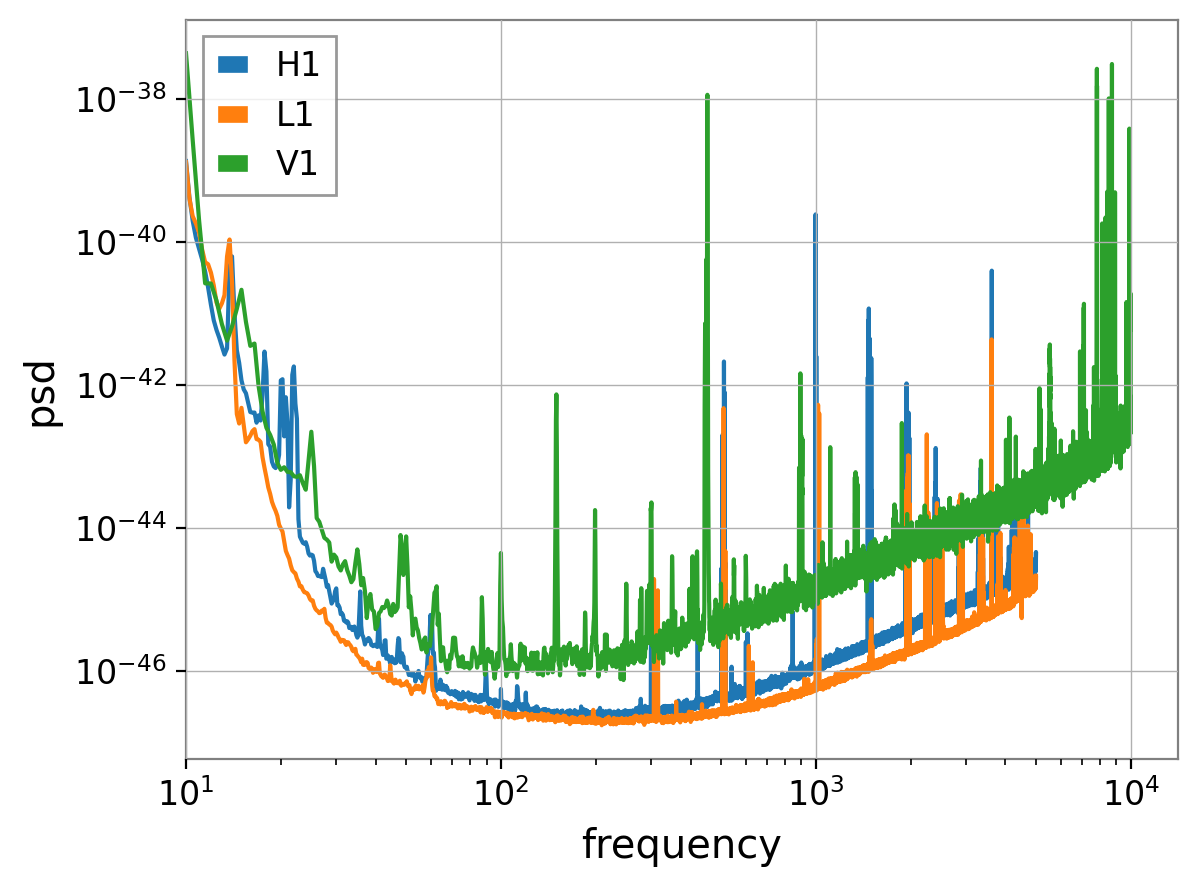

In [27]:
# Plot raw PSD
plt.figure()
for i, ifo in enumerate(lm.ifos): 
    freq, psd = lm.psd_dict[ifo].transpose()
    plt.loglog(freq, psd, color=f'C{i}', label=ifo)
plt.xlabel('frequency')
plt.ylabel('psd')
plt.legend()
plt.xlim(10,)
plt.show()

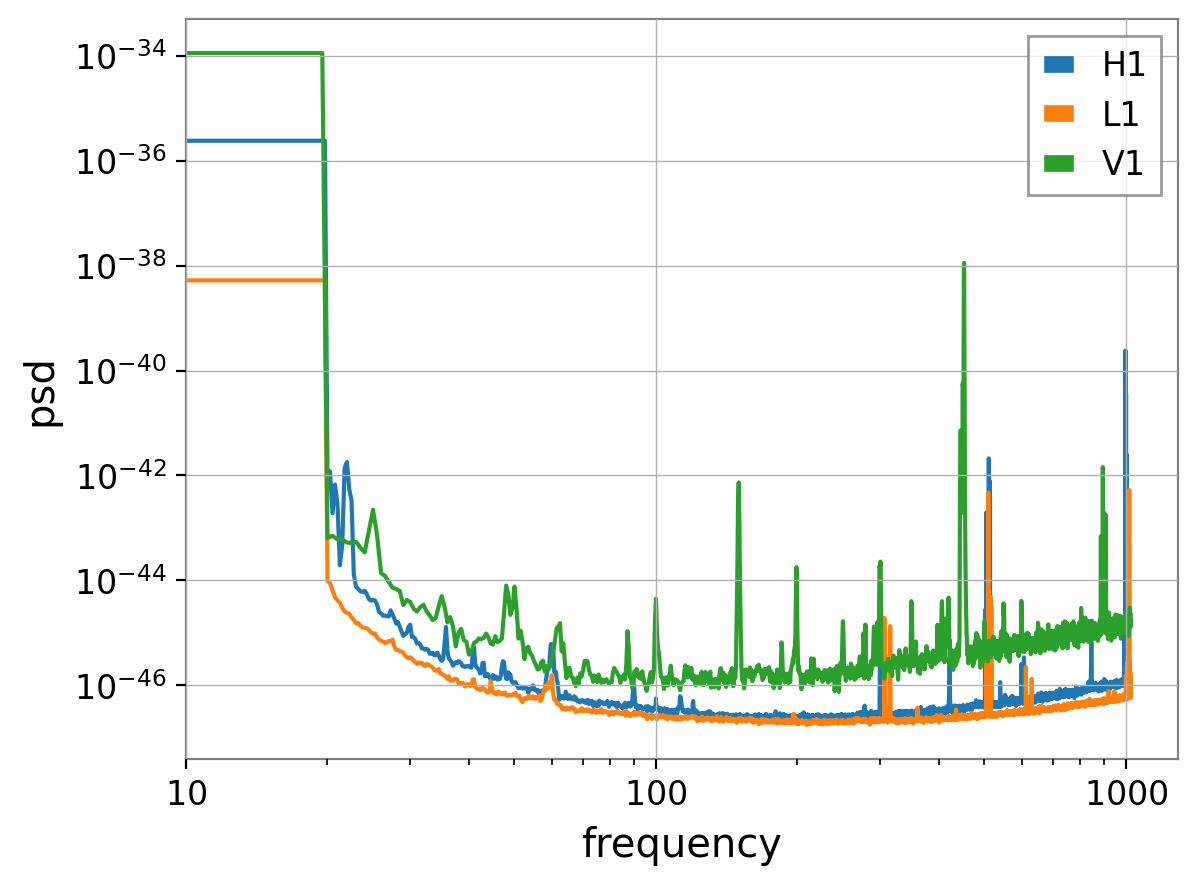

In [3]:
# Plot conditioned PSD
plt.figure()
for i, ifo in enumerate(lm.ifos): 
    freq, psd = lm.conditioned_psd_dict[ifo].transpose()
    plt.loglog(freq, psd, color=f'C{i}', label=ifo)
plt.xlabel('frequency')
plt.ylabel('psd')
plt.legend()
plt.xlim(10,)
plt.show()

### Plot ACF

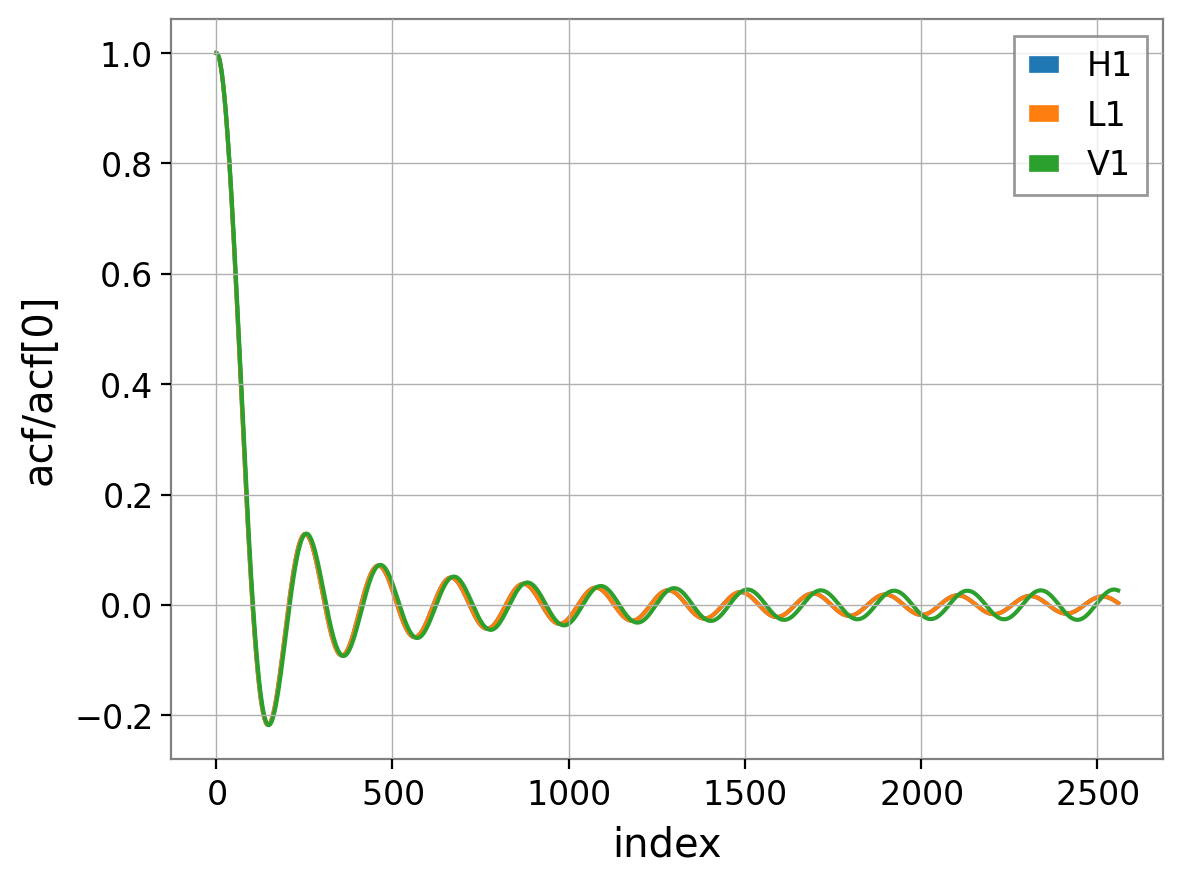

In [4]:
plt.figure()
for i, ifo in enumerate(lm.ifos): 
    acf = lm.rho_dict[ifo]
    plt.plot(acf/acf[0], color=f'C{i}', label=ifo)
plt.xlabel('index')
plt.ylabel('acf/acf[0]')
plt.legend()
plt.show()

### Get injection

In [5]:
# get reference parameters
with open('./input/injection.json') as f:
    reference_parameters = json.load(f)

# Get detector delay times 
dt_dict = lm.waveform_manager.antenna_and_time_manager.compute_time_delay_dict(
    data['runs']['full']['kwargs']['right_ascension'], 
    data['runs']['full']['kwargs']['declination'], 
    lm.reference_time, 
    lm.ifos
)

In [6]:
# Get injection
reference_parameters_transformed = run_sampler.modify_parameters(reference_parameters, data['runs']['full']['args'])
injection_dict = lm.waveform_manager.get_projected_waveform(
    reference_parameters_transformed,
    lm.ifos,
    lm.time_dict,
    lm.f22_start, 
    lm.f_ref
)
# Whiten injection
injection_dict_whitened = {ifo : utils.whitenData(
    injection_dict[ifo], 
    lm.time_dict[ifo],
    lm.conditioned_psd_dict[ifo][:, 1], 
    lm.conditioned_psd_dict[ifo][:, 0]
) for ifo in lm.ifos}

warning! neither mean_anomaly nor mean_anomaly_periastron in df.columns!


### Plot strain

2048.0
1.25


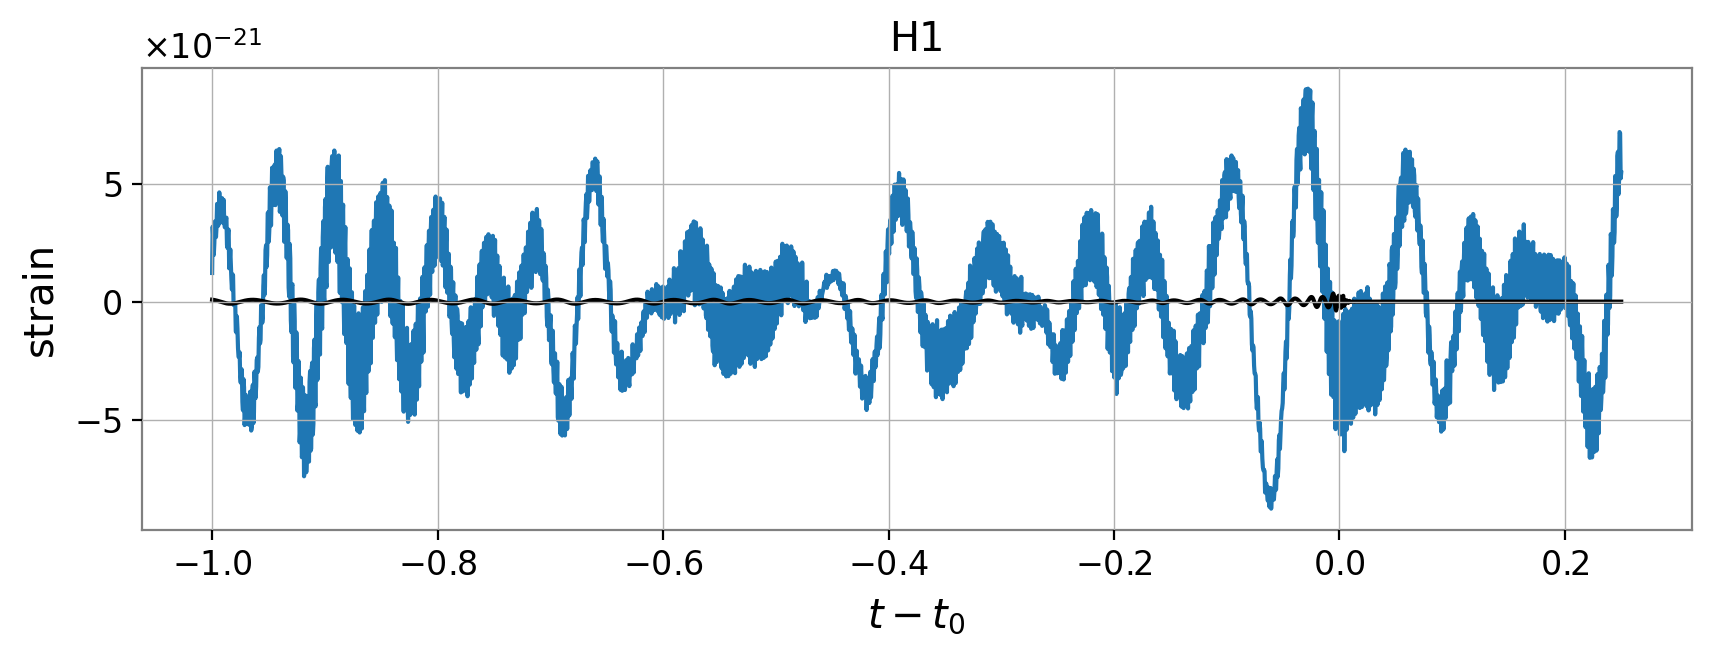

2048.0000000004657
1.25


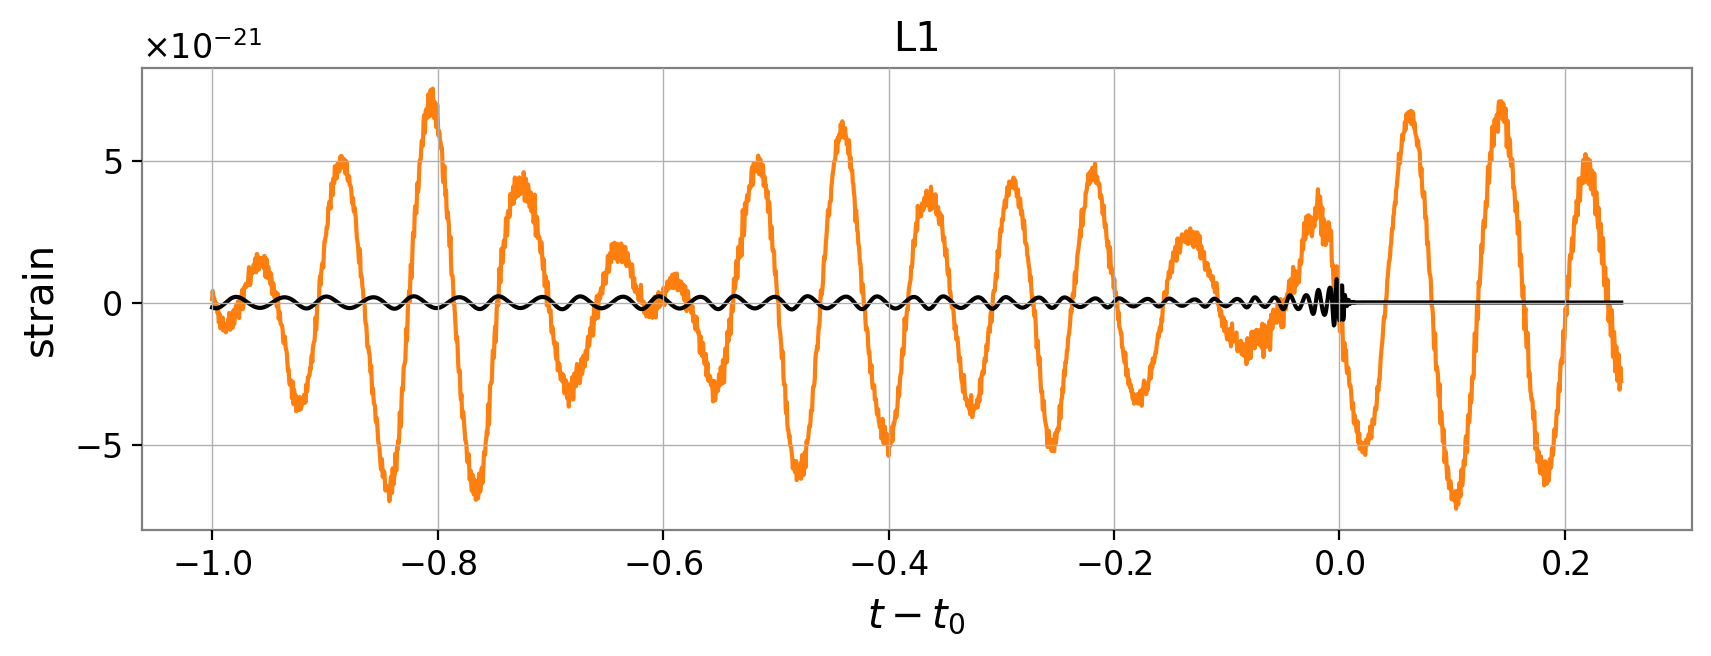

2048.0
1.25


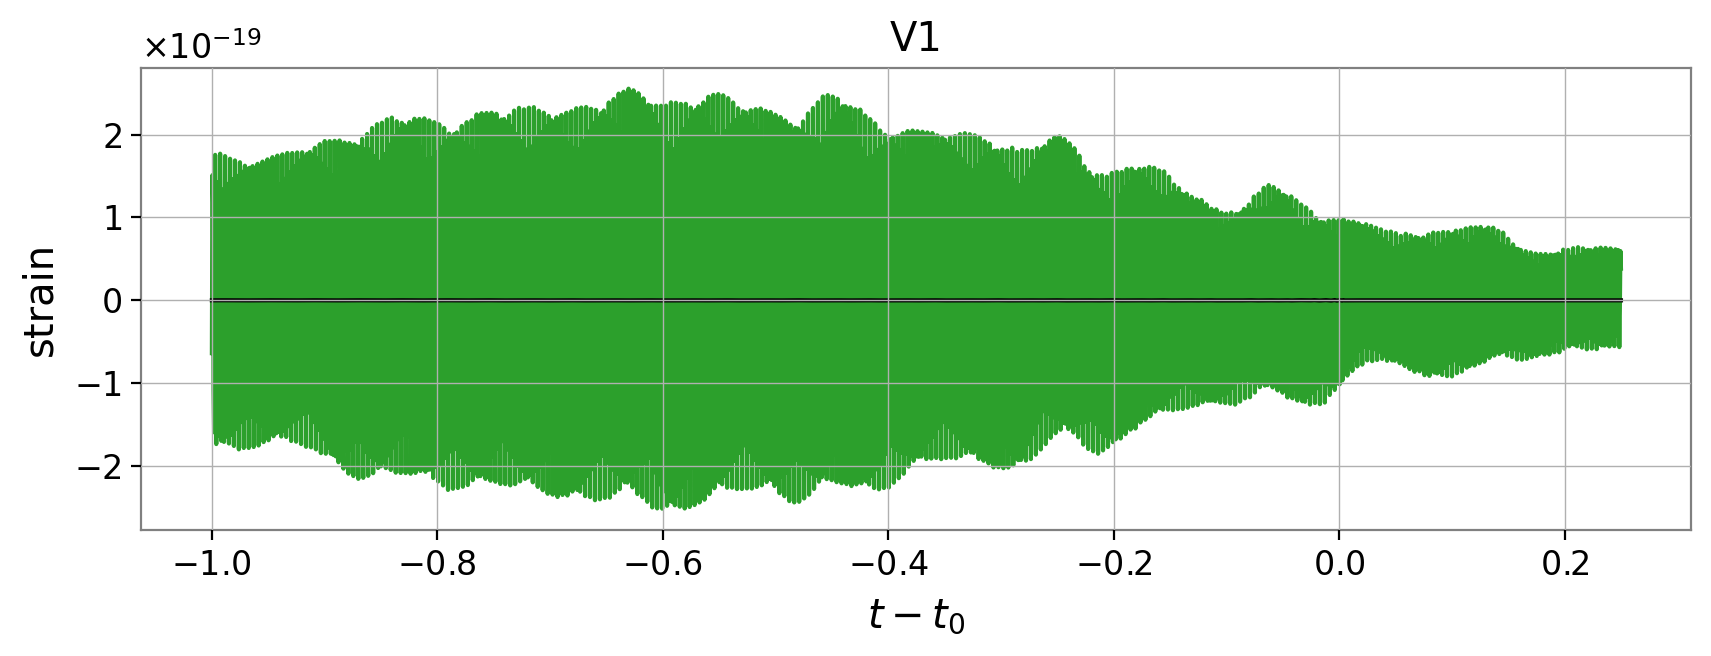

In [7]:
# Colored strain 
for i, ifo in enumerate(lm.ifos): 

    times = lm.time_dict[ifo] - lm.reference_time - dt_dict[ifo]

    print(1/np.diff(times)[0])
    print(times[-1] - times[0])

    plt.figure(figsize=(10, 3))
    plt.plot(times, lm.data_dict[ifo], color=f'C{i}')
    plt.plot(times, injection_dict[ifo], color='k')
    plt.title(ifo)
    plt.xlabel('$t - t_0$')
    plt.ylabel('strain')
    plt.show()

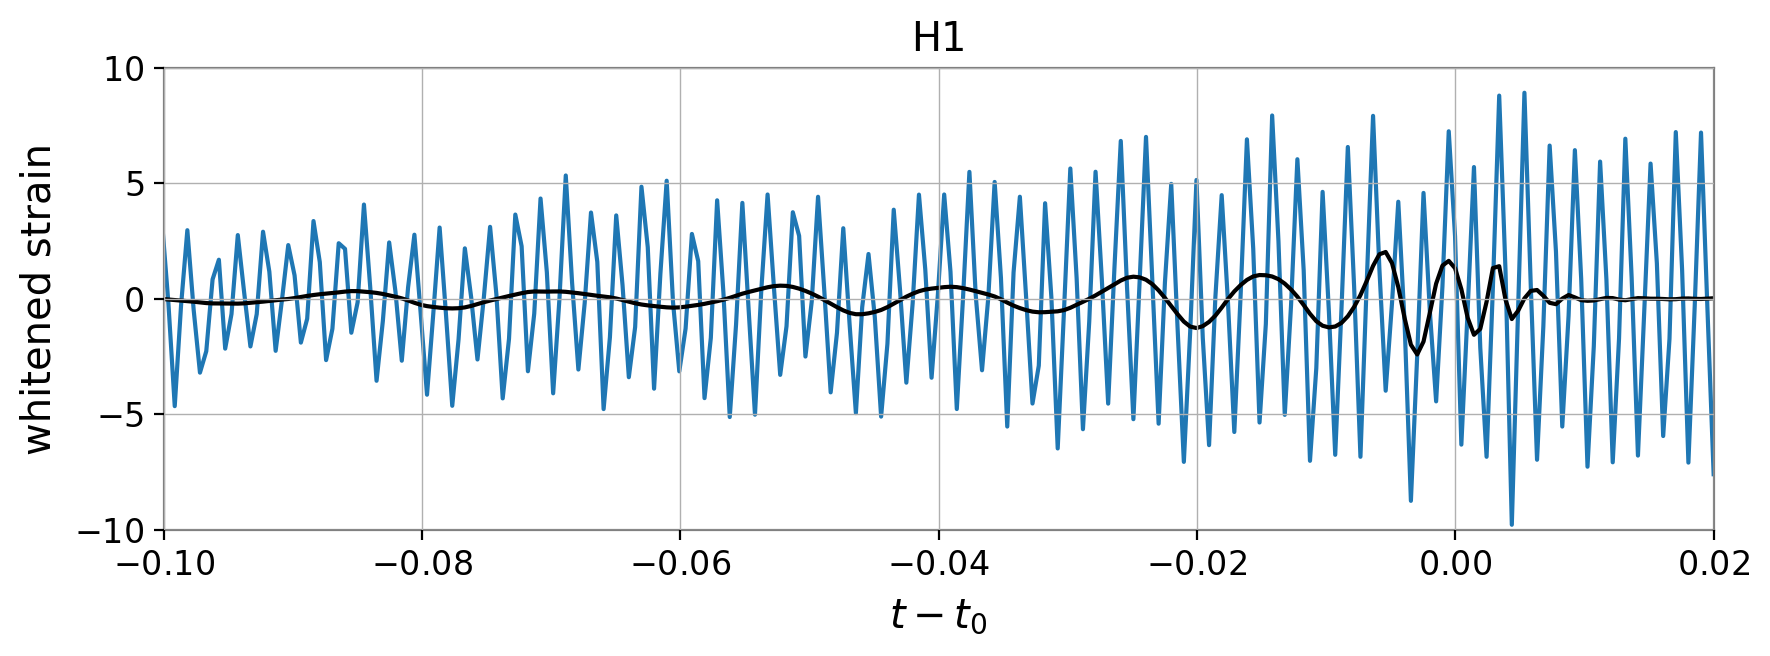

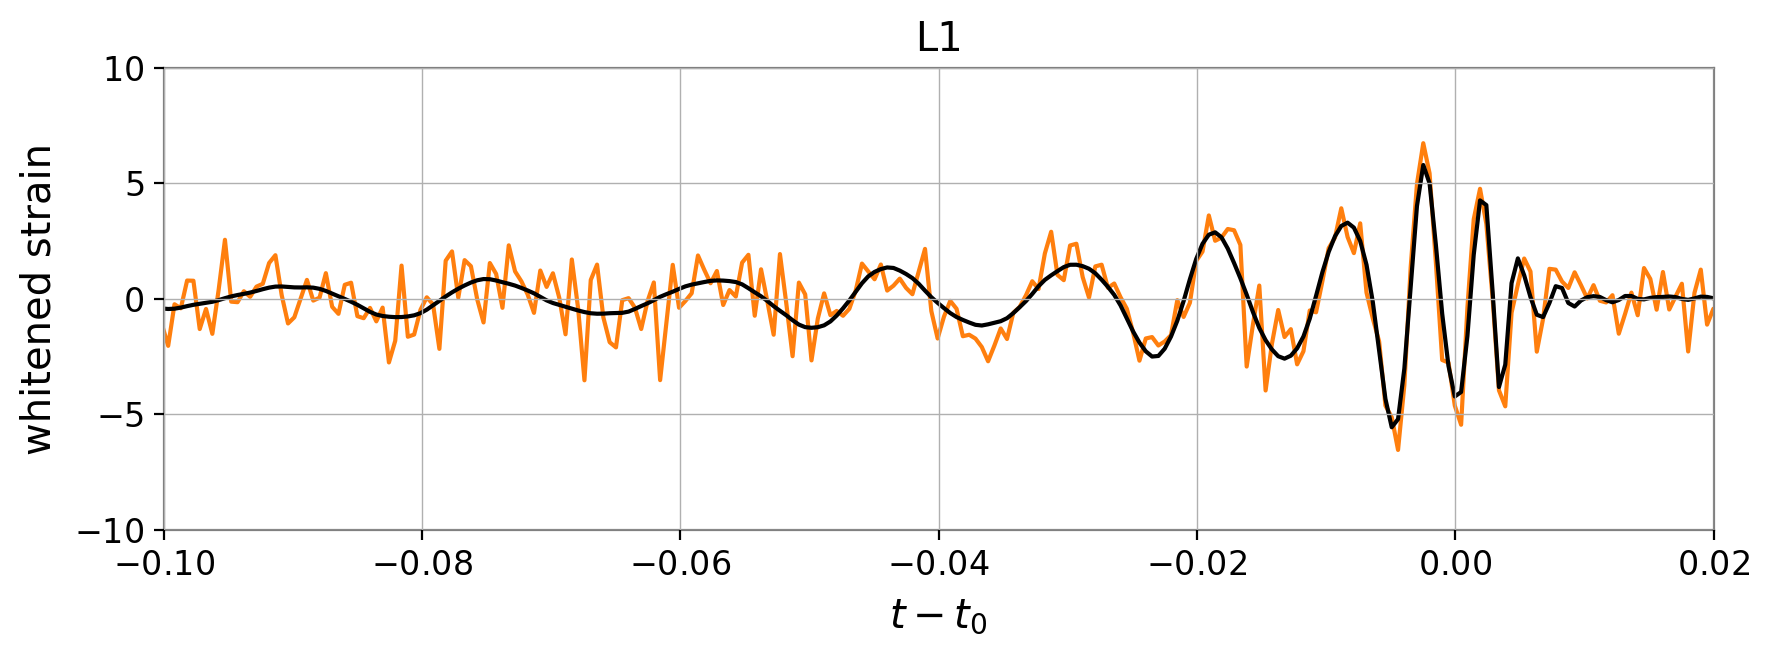

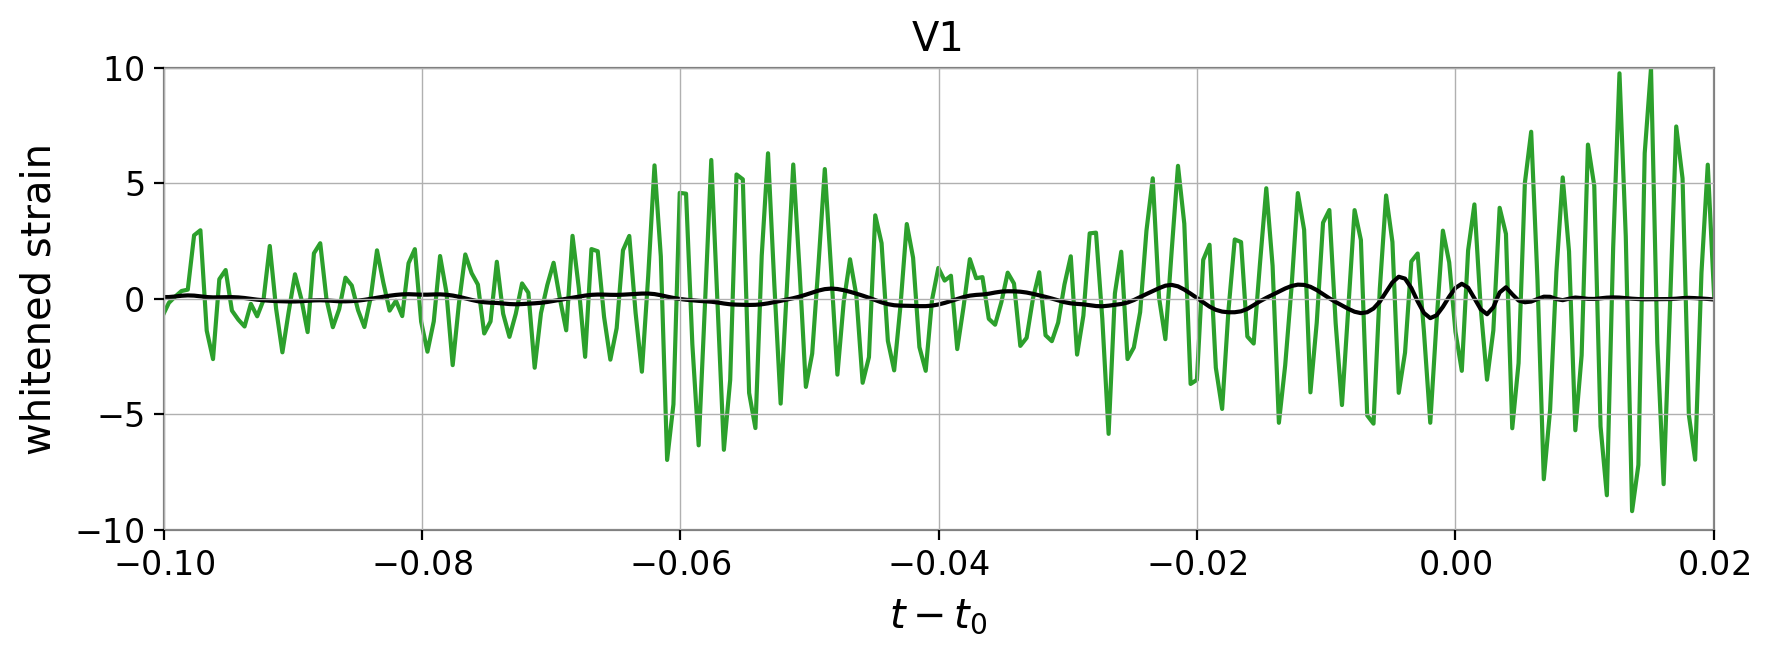

In [13]:
# Whitened strain cropped
for i, ifo in enumerate(lm.ifos): 

    times = lm.time_dict[ifo] - lm.reference_time - dt_dict[ifo]

    plt.figure(figsize=(10, 3))
    plt.plot(times, lm.whitened_data_dict[ifo], color=f'C{i}')
    plt.plot(times, injection_dict_whitened[ifo], color='k')
    plt.title(ifo)
    plt.xlabel('$t - t_0$')
    plt.ylabel('whitened strain')
    plt.xlim(-0.1, 0.02)
    plt.ylim(-10,10)
    plt.show()

### Cumulative SNR check

In [25]:
times_L1 = lm.time_dict['L1'] - lm.reference_time - dt_dict['L1']
dt = times_L1[1] - times_L1[0]
cum_snr = np.sqrt(np.cumsum(injection_dict_whitened['L1'][:]**2))
cum_snr_2 = np.sqrt(np.cumsum(injection_dict_whitened['L1'][::-1]**2))

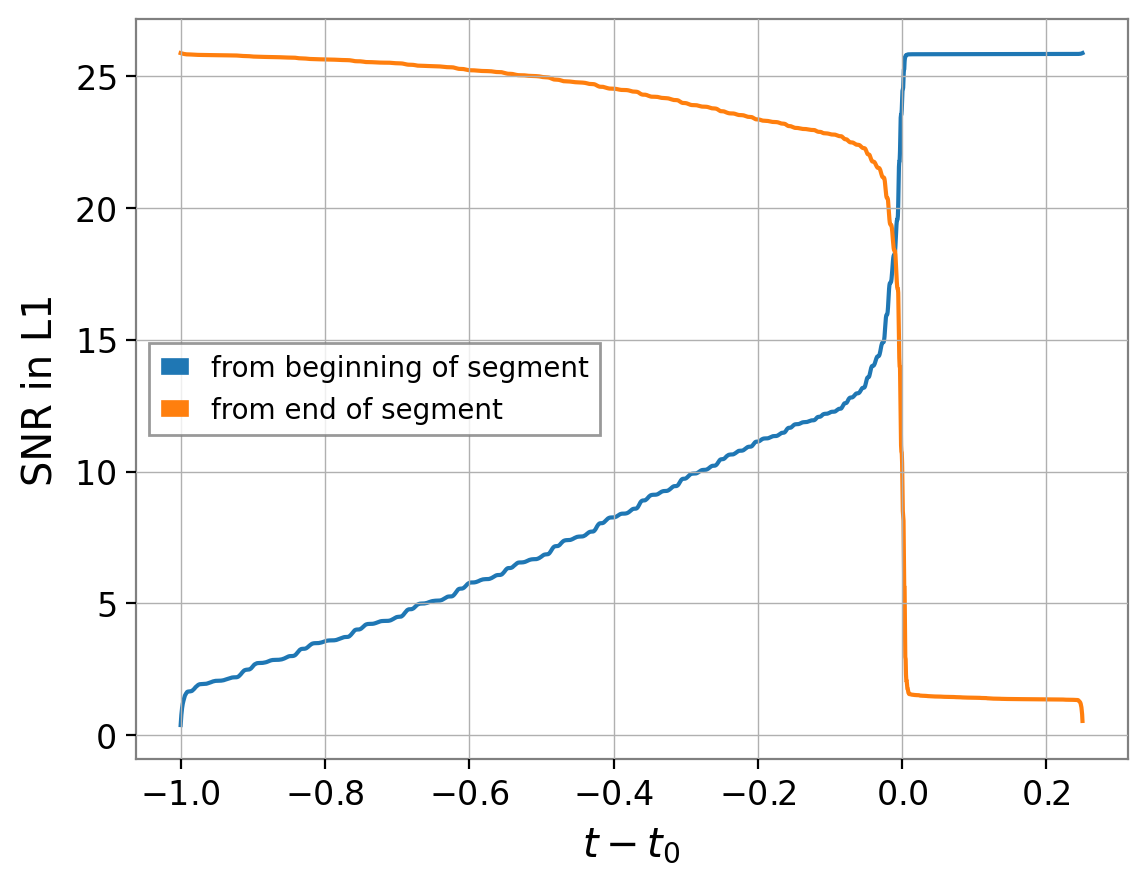

In [26]:
plt.plot(times_L1, cum_snr, label='from beginning of segment')
plt.plot(times_L1[::-1], cum_snr_2, label='from end of segment')
plt.legend(fontsize=10)
plt.xlabel(r'$t-t_0$')
plt.ylabel('SNR in L1');

In [12]:
print('Tstart =', lm.reference_time - 1)
print('Tend =', lm.reference_time + 0.25)

Tstart = 1238175799.0930877
Tend = 1238175800.3430877
